In [1]:
# Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Kshitiz Bhargava 21BCE2067

In [2]:
# Step 1: Load and preprocess the MNIST dataset
# The MNIST dataset is commonly used for training GANs due to its simple structure.
# Here we load the dataset and normalize it to the range [-1, 1] for better training of the GAN.

(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape the images to add a channel dimension (required by Conv2D) and normalize them
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to the range [-1, 1]

# Batch and shuffle the dataset
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Create a tf.data.Dataset pipeline for efficient data loading
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Kshitiz Bhargava 21BCE2067

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# Step 2: Define the Generator Model
# The generator takes random noise as input and transforms it into a synthetic image.
# The model progressively upsamples the input through transposed convolution layers to generate a 28x28 image.

def make_generator_model():
    model = tf.keras.Sequential()
    
    # First layer: Fully connected layer to reshape input noise into a 7x7x256 feature map
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Reshape into 7x7x256 feature maps
    model.add(layers.Reshape((7, 7, 256)))
    
    # First transposed convolution: Upsampling to 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second transposed convolution: Upsampling to 28x28
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Output layer: A single-channel (grayscale) image, using the 'tanh' activation to return pixel values in the range [-1, 1]
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

generator = make_generator_model()
# Kshitiz Bhargava 21BCE2067

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Step 3: Define the Discriminator Model
# The discriminator is a binary classifier that determines whether an input image is real or fake.
# It uses convolutional layers to downsample the input and a dense layer to output a probability.

def make_discriminator_model():
    model = tf.keras.Sequential()
    
    # First convolutional layer: Downsample to 14x14x64
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second convolutional layer: Downsample to 7x7x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Flatten the feature map and output a single score using a dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

discriminator = make_discriminator_model()

# Kshitiz Bhargava 21BCE2067

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Step 4: Define the Loss Functions and Optimizers
# GANs involve two loss functions: 
# - The discriminator's loss: How well it distinguishes between real and fake images.
# - The generator's loss: How well it tricks the discriminator into classifying generated images as real.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss: Compares the real and fake outputs with their respective labels (1 for real, 0 for fake)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss: The generator tries to make the fake images as close as possible to real, so the label is 1 for fake
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers for both the generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Kshitiz Bhargava 21BCE2067

In [6]:
# Step 5: Define the Training Loop
# The training loop involves generating images, evaluating them using the discriminator, and calculating loss to improve both models.

EPOCHS = 75
noise_dim = 100
num_examples_to_generate = 16

# Seed is used for generating images and tracking progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Training step: One step of training involves updating both the generator and discriminator
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    # Plotting the generated images
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.show()

# Full training loop: Trains the GAN over a specified number of epochs
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        
        # Generate images at the end of each epoch
        generate_and_save_images(generator, epoch + 1, seed)
        
        print(f'Epoch {epoch + 1} completed')
        
        # Kshitiz Bhargava 21BCE2067

2024-09-09 07:50:31.012093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


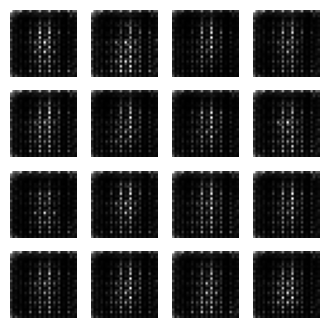

Epoch 1 completed


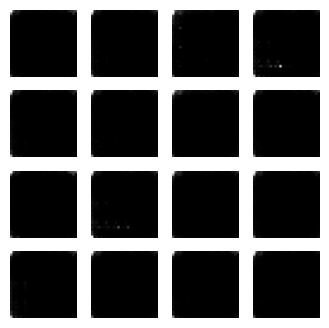

Epoch 2 completed


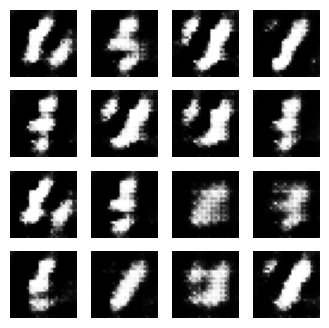

Epoch 3 completed


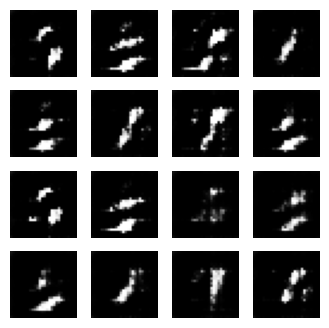

Epoch 4 completed


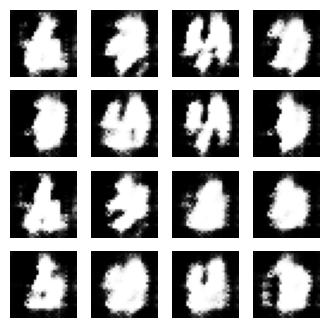

Epoch 5 completed


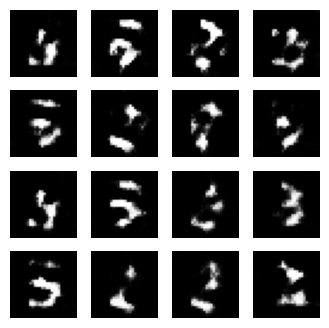

Epoch 6 completed


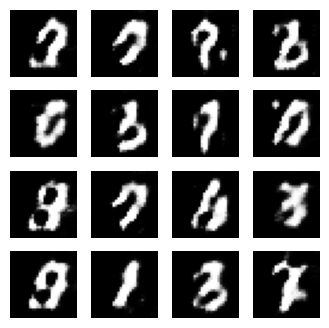

Epoch 7 completed


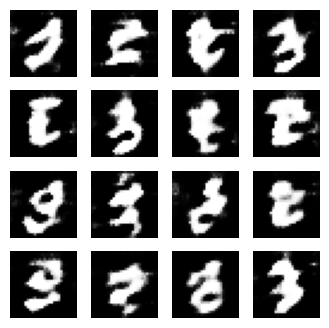

Epoch 8 completed


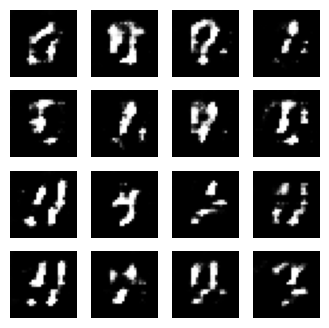

Epoch 9 completed


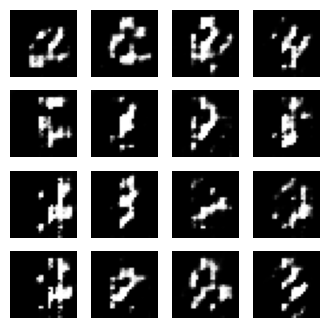

Epoch 10 completed


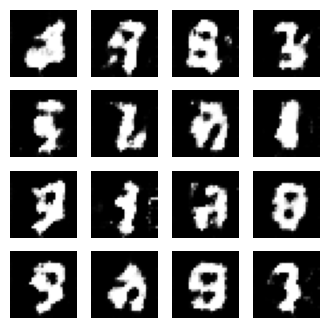

Epoch 11 completed


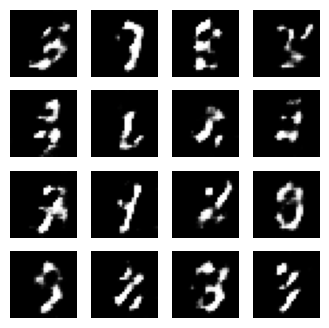

Epoch 12 completed


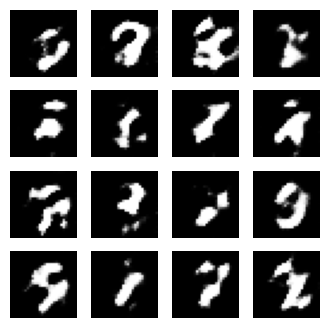

Epoch 13 completed


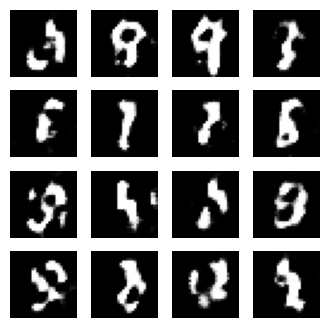

Epoch 14 completed


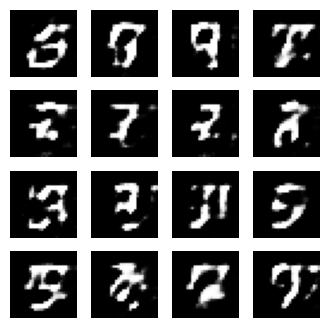

Epoch 15 completed


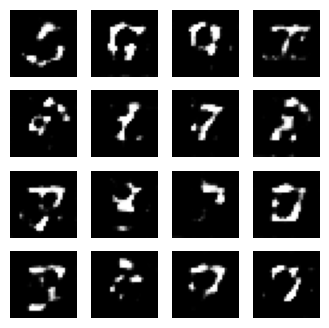

Epoch 16 completed


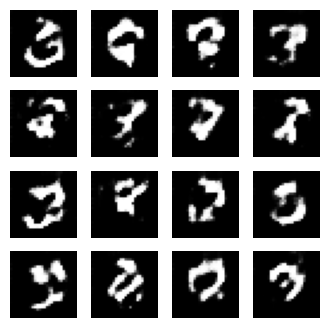

Epoch 17 completed


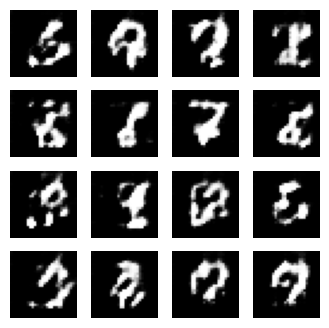

Epoch 18 completed


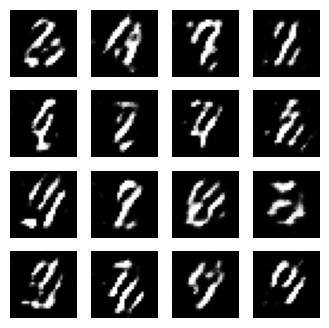

Epoch 19 completed


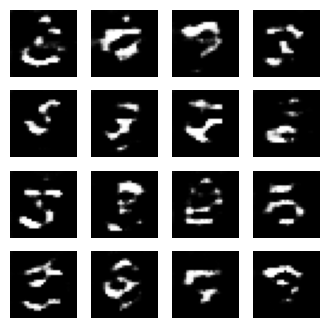

Epoch 20 completed


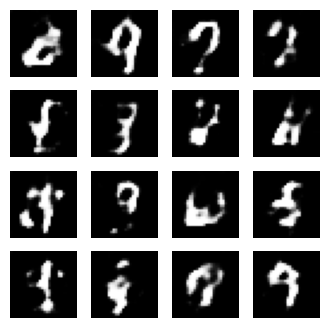

Epoch 21 completed


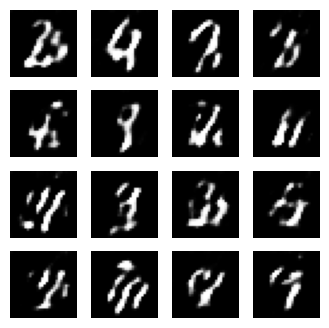

Epoch 22 completed


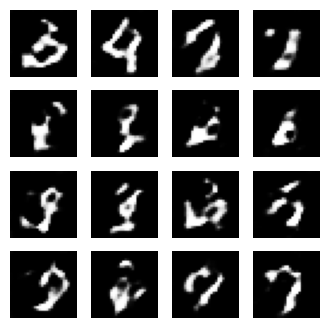

Epoch 23 completed


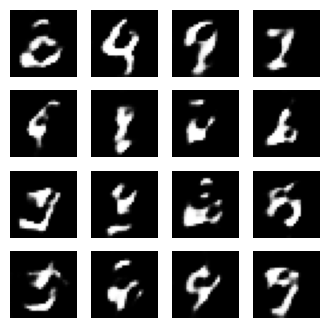

Epoch 24 completed


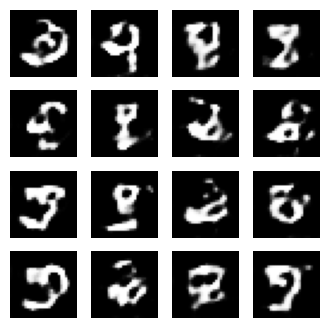

Epoch 25 completed


Epoch 26 completed


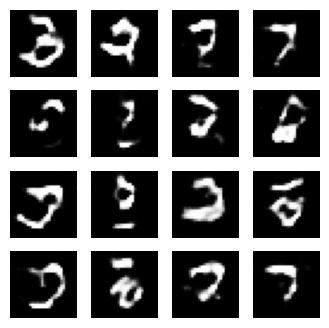

Epoch 27 completed


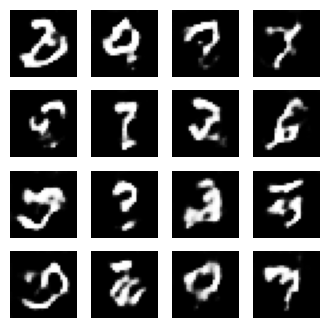

Epoch 28 completed


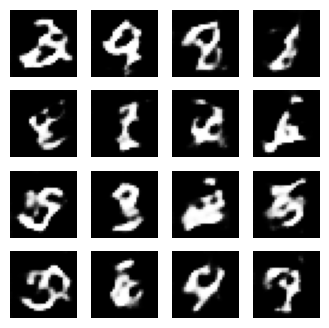

Epoch 29 completed


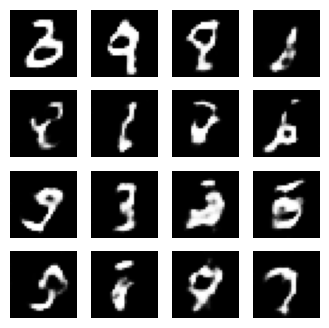

Epoch 30 completed


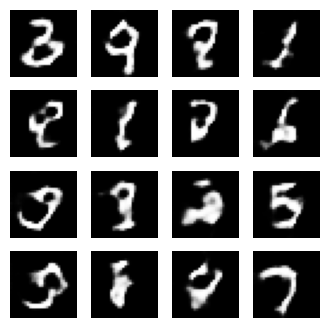

Epoch 31 completed


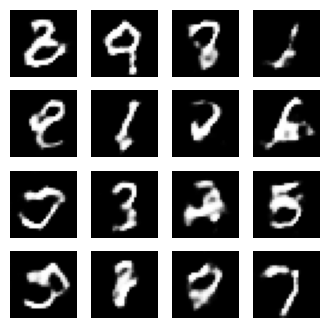

Epoch 32 completed


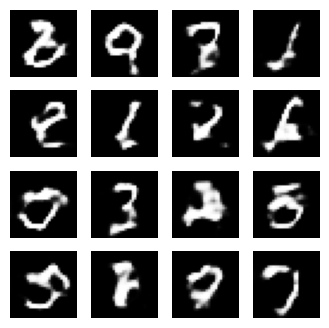

Epoch 33 completed


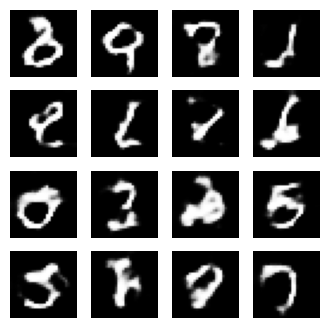

Epoch 34 completed


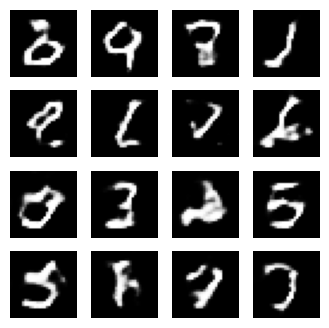

Epoch 35 completed


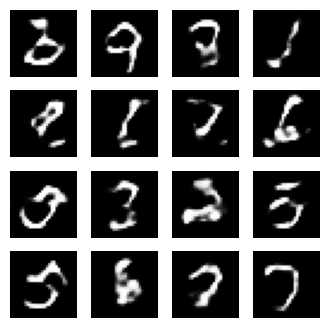

Epoch 36 completed


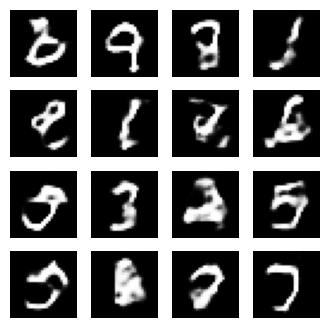

Epoch 37 completed


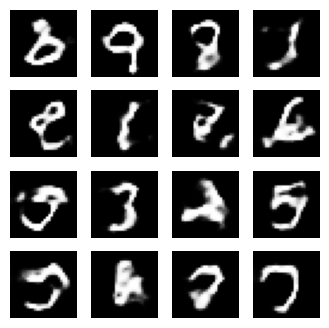

Epoch 38 completed


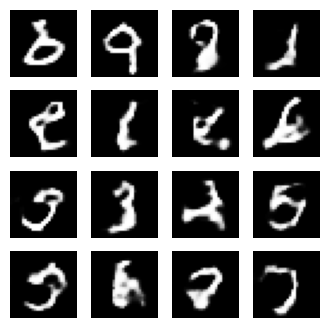

Epoch 39 completed


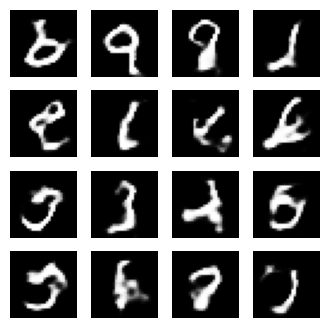

Epoch 40 completed


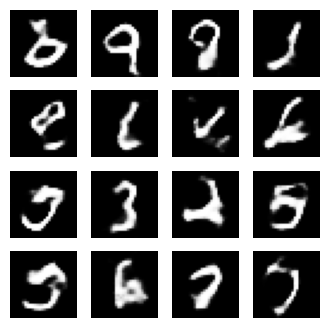

Epoch 41 completed


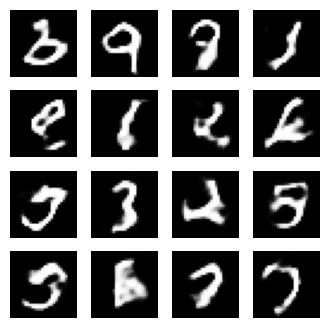

Epoch 42 completed


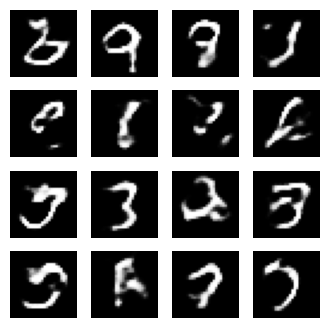

Epoch 43 completed


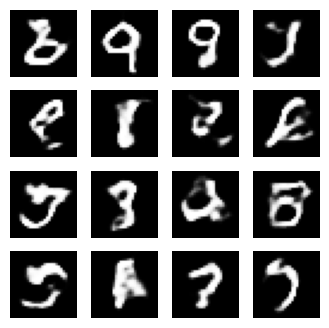

Epoch 44 completed


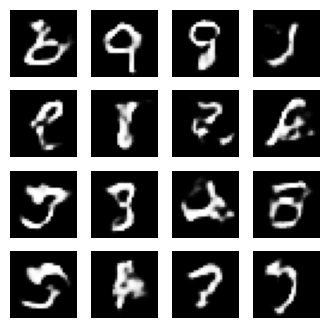

Epoch 45 completed


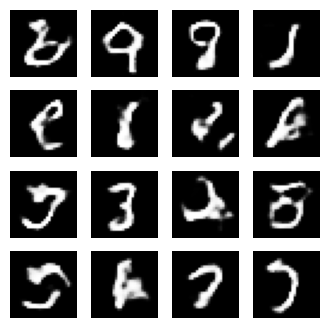

Epoch 46 completed


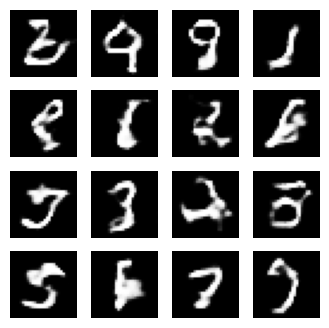

Epoch 47 completed


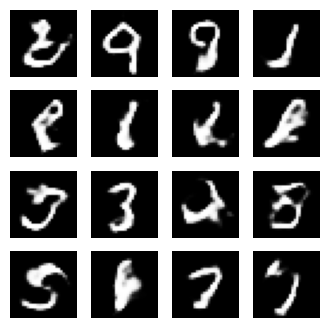

Epoch 48 completed


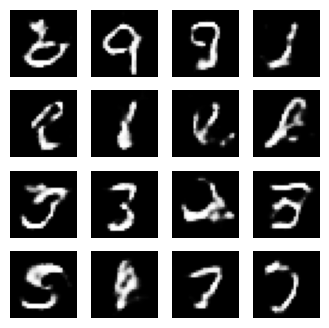

Epoch 49 completed


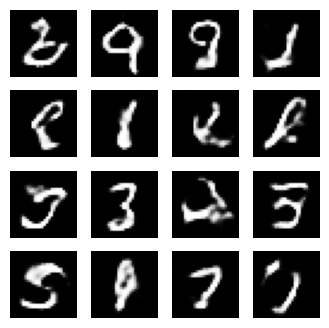

Epoch 50 completed


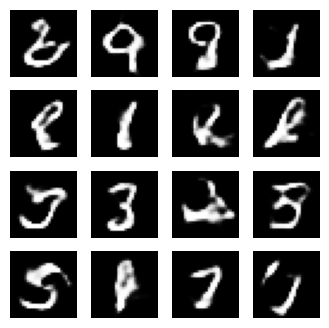

Epoch 51 completed


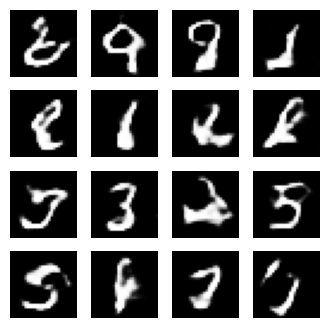

Epoch 52 completed


Epoch 53 completed


Epoch 54 completed


Epoch 55 completed


Epoch 56 completed


Epoch 57 completed


Epoch 58 completed


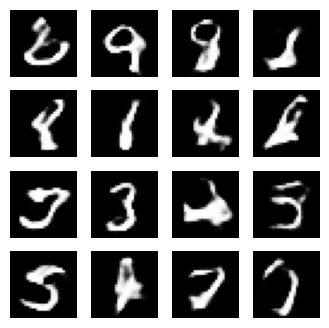

Epoch 59 completed


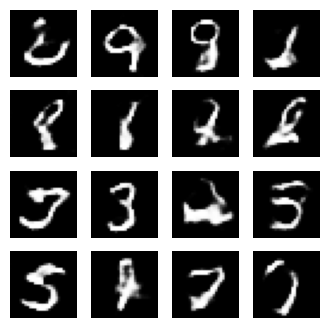

Epoch 60 completed


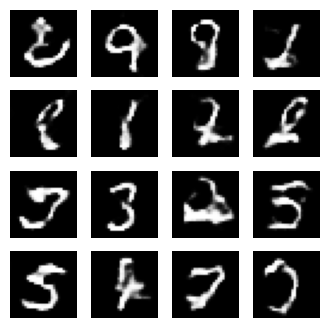

Epoch 61 completed


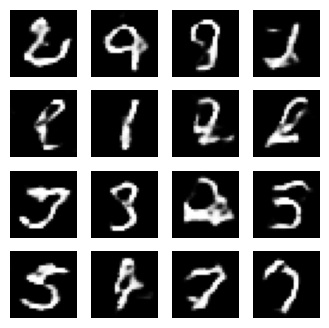

Epoch 62 completed


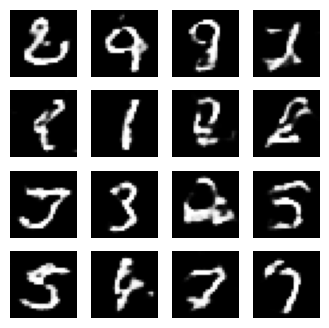

Epoch 63 completed


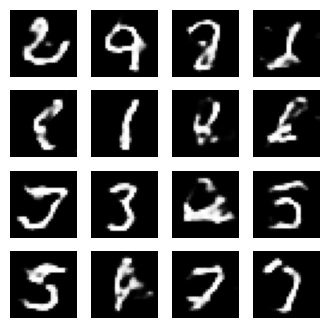

Epoch 64 completed


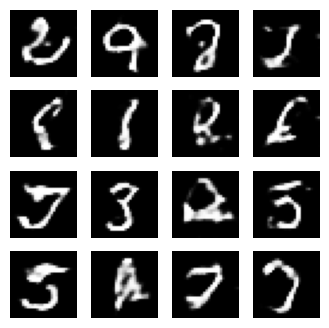

Epoch 65 completed


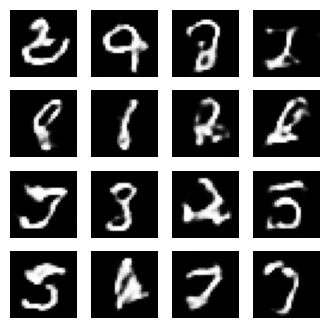

Epoch 66 completed


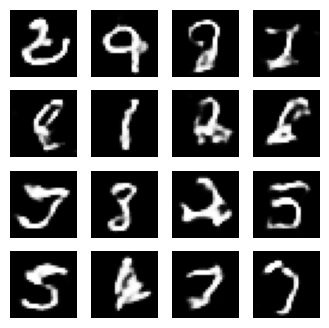

Epoch 67 completed


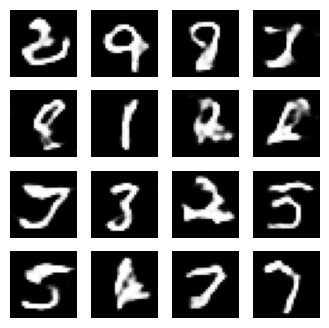

Epoch 68 completed


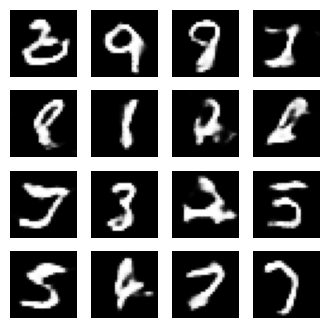

Epoch 69 completed


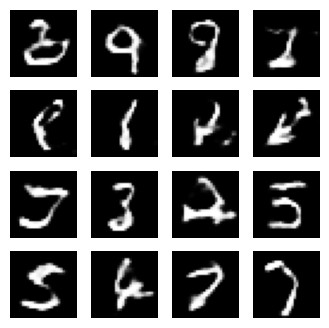

Epoch 70 completed


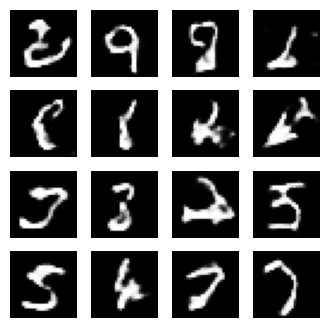

Epoch 71 completed


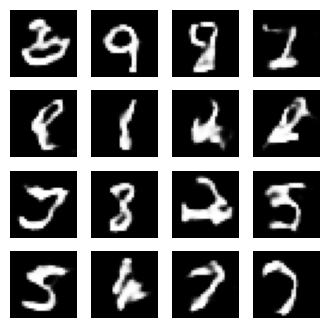

Epoch 72 completed


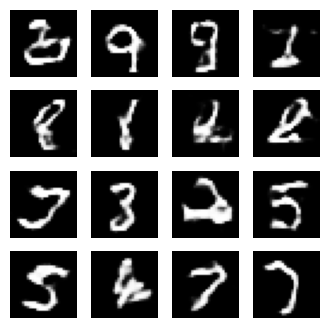

Epoch 73 completed


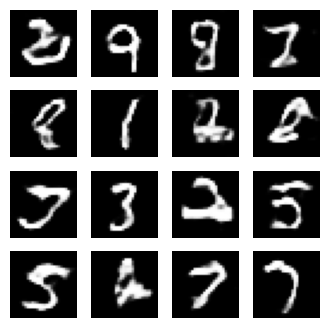

Epoch 74 completed


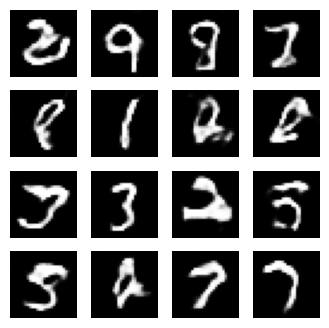

Epoch 75 completed


In [7]:
# Step 6: Train the GAN model
train(train_dataset, EPOCHS)

# Kshitiz Bhargava 21BCE2067